<a href="https://colab.research.google.com/github/malofeevakate/car_price_linear_regression/blob/main/LinRegr_car_price_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [ ]:
# трейн
X = pd.read_csv('linreg_train.csv')
X.head()

,Unnamed: 0,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker
0,5912,Passat,2019,Manual,15435,Diesel,150,51.4,2.0,vw
1,2828,A Class,2019,Semi-Auto,17945,Diesel,145,65.7,1.5,mercedes
2,2329,Focus,2017,Manual,20102,Petrol,20,60.1,1.0,ford
3,5705,C-HR,2018,Automatic,8661,Hybrid,135,74.3,1.8,toyota
4,4985,Fiesta,2020,Manual,10,Petrol,150,58.9,1.0,ford


In [ ]:
# удалим ненужные данные
X.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
# пропусков нет
# количественные фичи - mileage, tax, mpg, engineSize
# качественные фичи - year, model, transmission, fuelType, car_maker
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64556 entries, 0 to 64555
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64556 non-null  object 
 1   year          64556 non-null  int64  
 2   transmission  64556 non-null  object 
 3   mileage       64556 non-null  int64  
 4   fuelType      64556 non-null  object 
 5   tax           64556 non-null  int64  
 6   mpg           64556 non-null  float64
 7   engineSize    64556 non-null  float64
 8   car_maker     64556 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 4.4+ MB


In [ ]:
# тест
X_test = pd.read_csv('linreg_test.csv')
X_test.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
X_test.describe()

,year,mileage,tax,mpg,engineSize,id
count,16139.000000,16139.000000,16139.000000,16139.000000,16139.000000,16139.000000
mean,2017.085321,23269.391970,118.959973,55.917969,1.718973,8069.000000
std,2.166389,21536.226359,65.589323,17.084942,0.589940,4659.072333
min,1970.000000,1.000000,0.000000,0.300000,0.000000,0.000000
25%,2016.000000,7147.000000,125.000000,47.100000,1.200000,4034.500000
50%,2017.000000,17406.000000,145.000000,55.400000,1.600000,8069.000000
75%,2019.000000,32793.500000,145.000000,64.200000,2.000000,12103.500000
max,2020.000000,177644.000000,580.000000,470.800000,6.200000,16138.000000


In [ ]:
# таргет
y = pd.read_csv('linreg_y_train.csv')

In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64556 entries, 0 to 64555
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  64556 non-null  int64
 1   price       64556 non-null  int64
dtypes: int64(2)
memory usage: 1008.8 KB


In [ ]:
y.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
y.price.describe()

count     64556.000000
mean      18136.018062
std       10266.777814
min         650.000000
25%       10991.000000
50%       15998.000000
75%       22490.000000
max      154998.000000
Name: price, dtype: float64

<AxesSubplot:>

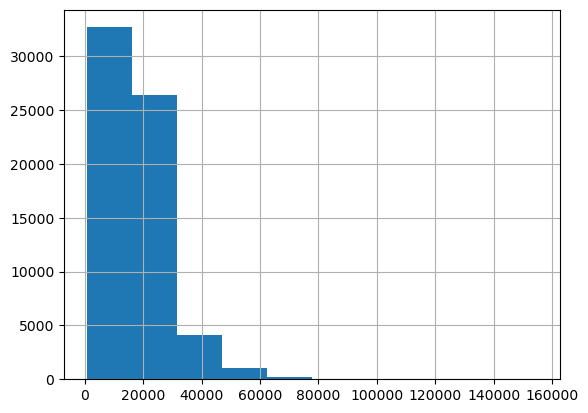

In [ ]:
# распределение цен скошено влево, унимодально
y.price.hist()

In [ ]:
# прологарифмируем цену для более сглаженного распределения
y['log_price'] = np.log(y.price)

<AxesSubplot:>

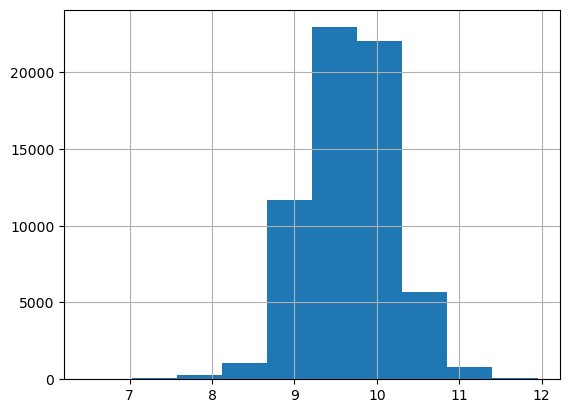

In [ ]:
y.log_price.hist()

In [ ]:
X['price'] = y.price
X['log_price'] = y.log_price

In [ ]:
# удалим явный выброс 2060 год
X = X.query('year < 2030')

### Преобразование качественных фичей  
Посмотрим на категориальные признаки, насколько они вариативны

In [ ]:
X.model.nunique()

155

In [ ]:
X.year.nunique()

25

In [ ]:
X.transmission.nunique()

4

In [ ]:
X.fuelType.nunique()

5

In [ ]:
X.car_maker.nunique()

7

Все категориальные фичи - мультиклассовые, но поскольку максимальная вариативность только у названия модели, ко всем остальным фичам можно применить dummies

In [ ]:
XX = pd.concat([X, X_test], axis = 0)

XX = pd.get_dummies(XX,
                                  prefix = ['year','fuelType','transmission','car_maker'],
                                  columns = ['year','fuelType','transmission','car_maker'],
                                  drop_first = False)

In [ ]:
X.shape, X_test.shape

((64555, 11), (16139, 10))

In [ ]:
# разделим обратно
X = XX.iloc[:64555]
X_test = XX.iloc[64555:]

In [ ]:
X.shape, X_test.shape

((64555, 50), (16139, 50))

теперь кодируем мультиклассовую категорию "модель"

In [ ]:
# Mean Encoding
means_map = X.groupby('model', as_index = False).log_price.mean() \
.rename(columns = {'log_price' : 'model_mean_enc'})
X = X.merge(means_map, how = 'left', on = 'model')
X_test = X_test.merge(means_map, how = 'left', on = 'model').fillna(0)

In [ ]:
# Smoothed means
agg = X.groupby('model', as_index = False).log_price.agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means + weight * means) / (counts + weight)
smooth_s = X.model.map(smooth)
X['model_s_mean_enc'] =  X.model.map(smooth)
X_test['model_s_mean_enc'] = X_test.model.map(smooth)

In [ ]:
X.drop(columns = 'model', inplace = True)
X_test.drop(columns = 'model', inplace = True)

### Оценка влияния предикторов на целевую переменную

C:\Users\User\AppData\Local\Temp\ipykernel_5624\16165321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['Maker'] = X['car_maker_audi'] + 2 * X['car_maker_bmw'] + 3 * X['car_maker_ford'] +\
C:\Users\User\AppData\Local\Temp\ipykernel_5624\16165321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2.Maker.replace([1, 2, 3, 4, 5, 6, 7], ['audi', 'bmw', 'ford', 'mercedes', 'skoda', 'toyota', 'vw'], inplace = True)


[Text(0.5, 0, 'Производитель'), Text(0, 0.5, 'Стоимость')]

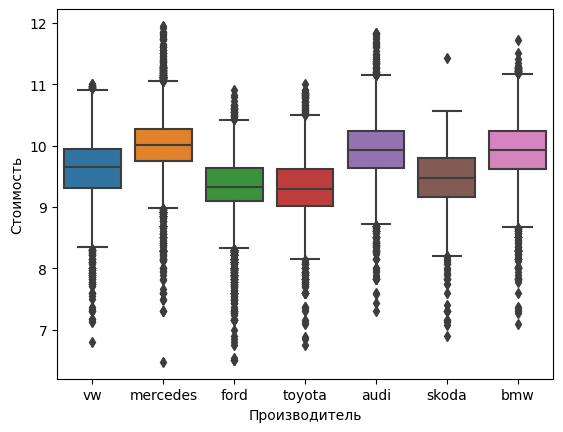

In [ ]:
# посмотрим на зависимость цены от производителя
X2 = X[['log_price']]

X2['Maker'] = X['car_maker_audi'] + 2 * X['car_maker_bmw'] + 3 * X['car_maker_ford'] +\
                 4 * X['car_maker_mercedes'] + 5 * X['car_maker_skoda'] + 6*X['car_maker_toyota'] + 7*X['car_maker_vw']

X2.Maker.replace([1, 2, 3, 4, 5, 6, 7], ['audi', 'bmw', 'ford', 'mercedes', 'skoda', 'toyota', 'vw'], inplace = True)

sns.boxplot(y = X2['log_price'], x = X2['Maker']).set(xlabel = u'Производитель', ylabel = u'Стоимость')

Обратим внимание, что у нас имеется две группы производителей, средние цены по которым между группами различаются, а внутри групп менее различны. Первая группа - это Мерседес, Ауди и БМВ, а вторая группа - остальные автомобили (Шкода, Тойота, Форд и Фольцваген). Скорее всего, и остальные показатели между группами различны. Поэтому логично разделить датасет на Премиум и Стандарт сегмент, и учить разные модели на разных данных

In [ ]:
X_premium = pd.concat([X.query('car_maker_audi == 1'),
                       X.query('car_maker_bmw == 1'),
                       X.query('car_maker_mercedes == 1')])

In [ ]:
X_standard = pd.concat([X.query('car_maker_ford == 1'),
                        X.query('car_maker_toyota == 1'),
                        X.query('car_maker_skoda == 1'),
                        X.query('car_maker_vw == 1')])

<AxesSubplot:>

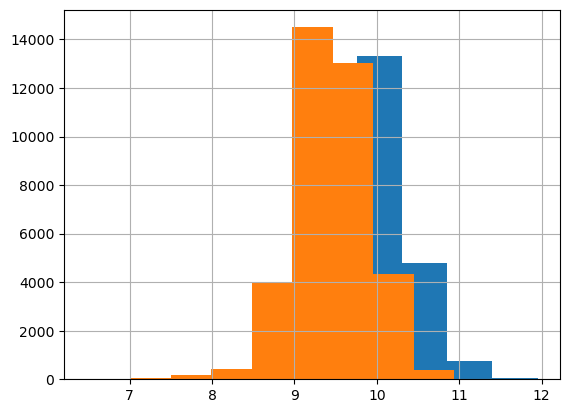

In [ ]:
# действительно, распределения цен на премиум и стандарт авто различны
X_premium.log_price.hist()
X_standard.log_price.hist()

Далее пройдемся по оценке влияния предикторов на таргет внутри групп

<AxesSubplot:title={'center':'Dependence of the premium Car price on mileage'}, xlabel='log_price', ylabel='mileage'>

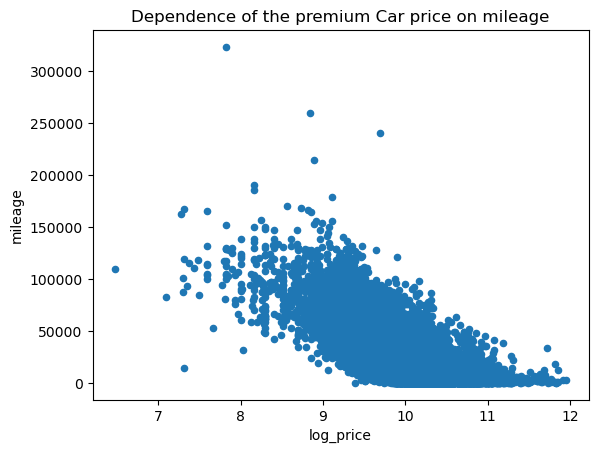

In [ ]:
X_premium.plot(x = 'log_price', y = 'mileage', kind = 'scatter', title = 'Dependence of the premium Car price on mileage')

<AxesSubplot:title={'center':'Dependence of the standard Car price on mileage'}, xlabel='log_price', ylabel='mileage'>

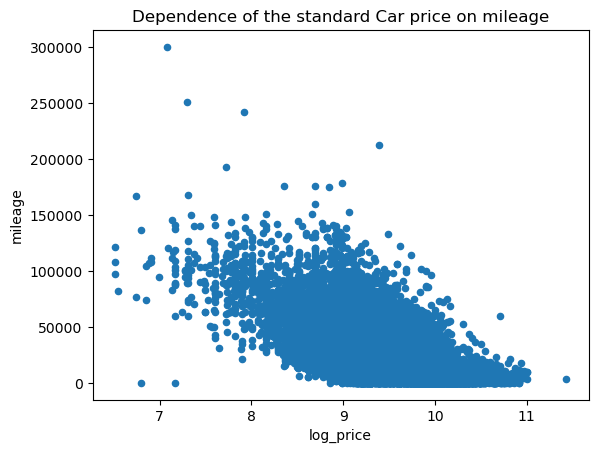

In [ ]:
X_standard.plot(x = 'log_price', y = 'mileage', kind = 'scatter', title = 'Dependence of the standard Car price on mileage')

<AxesSubplot:title={'center':'Dependence of the premium Car price on engine size'}, xlabel='log_price', ylabel='engineSize'>

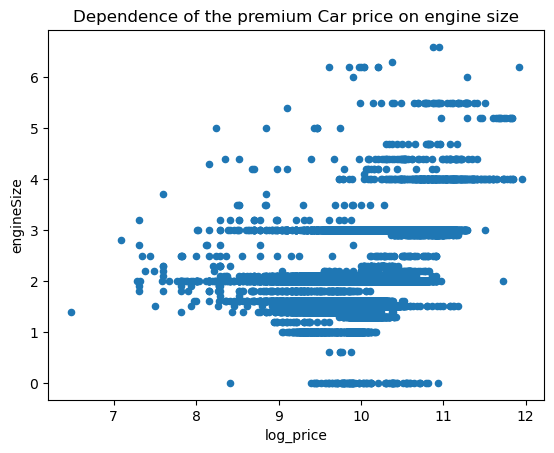

In [ ]:
X_premium.plot(x = 'log_price', y = 'engineSize', kind = 'scatter', title = 'Dependence of the premium Car price on engine size')

<AxesSubplot:title={'center':'Dependence of the standard Car price on engine size'}, xlabel='log_price', ylabel='engineSize'>

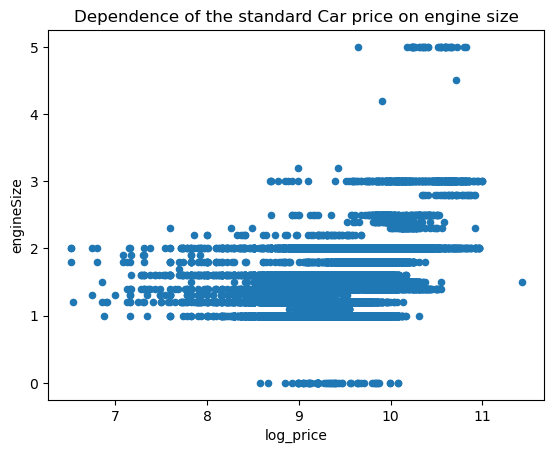

In [ ]:
X_standard.plot(x = 'log_price', y = 'engineSize', kind = 'scatter', title = 'Dependence of the standard Car price on engine size')

<AxesSubplot:title={'center':'Dependence of the premium Car price on tax'}, xlabel='log_price', ylabel='tax'>

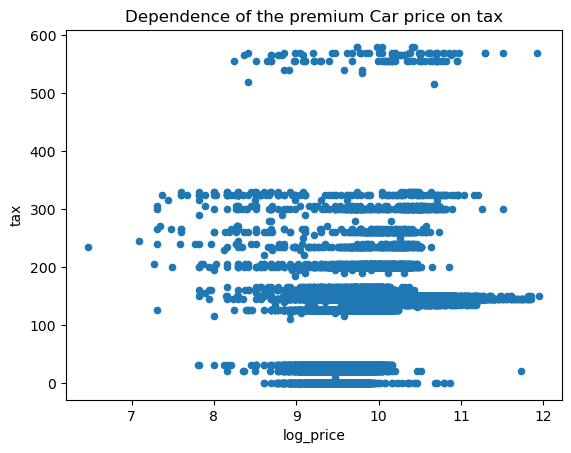

In [ ]:
X_premium.plot(x = 'log_price', y = 'tax', kind = 'scatter', title = 'Dependence of the premium Car price on tax')

<AxesSubplot:title={'center':'Dependence of the standard Car price on tax'}, xlabel='log_price', ylabel='tax'>

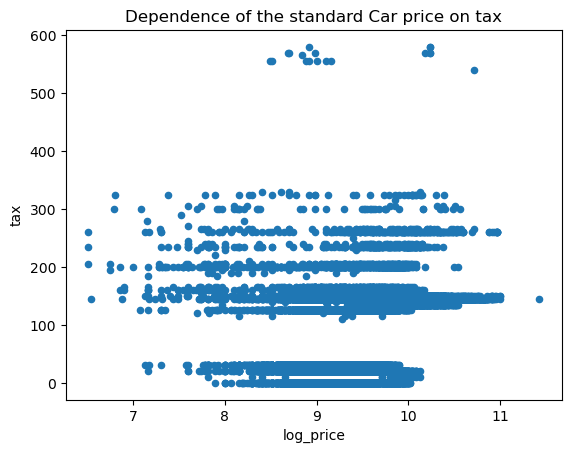

In [ ]:
X_standard.plot(x = 'log_price', y = 'tax', kind = 'scatter', title = 'Dependence of the standard Car price on tax')

<AxesSubplot:title={'center':'Dependence of the premium Car price on mpg'}, xlabel='log_price', ylabel='mpg'>

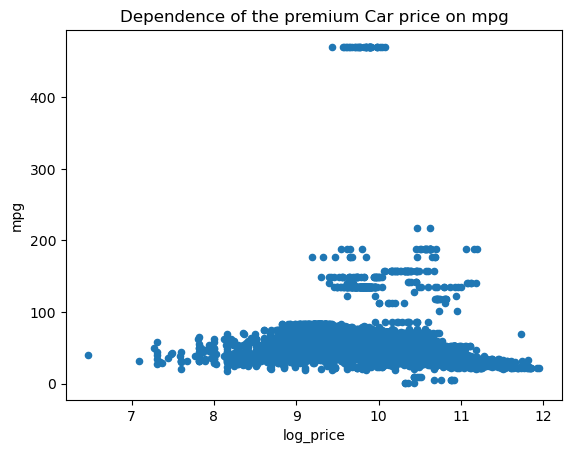

In [ ]:
X_premium.plot(x = 'log_price', y = 'mpg', kind = 'scatter', title = 'Dependence of the premium Car price on mpg')

<AxesSubplot:title={'center':'Dependence of the standard Car price on mpg'}, xlabel='log_price', ylabel='mpg'>

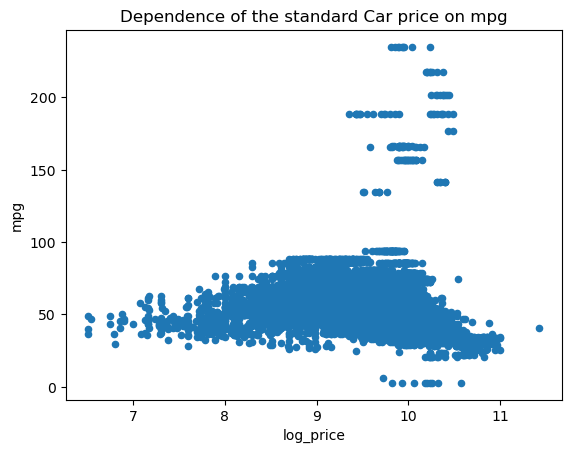

In [ ]:
X_standard.plot(x = 'log_price', y = 'mpg', kind = 'scatter', title = 'Dependence of the standard Car price on mpg')

CAR PREMIUM CORRELATIONS


<AxesSubplot:>

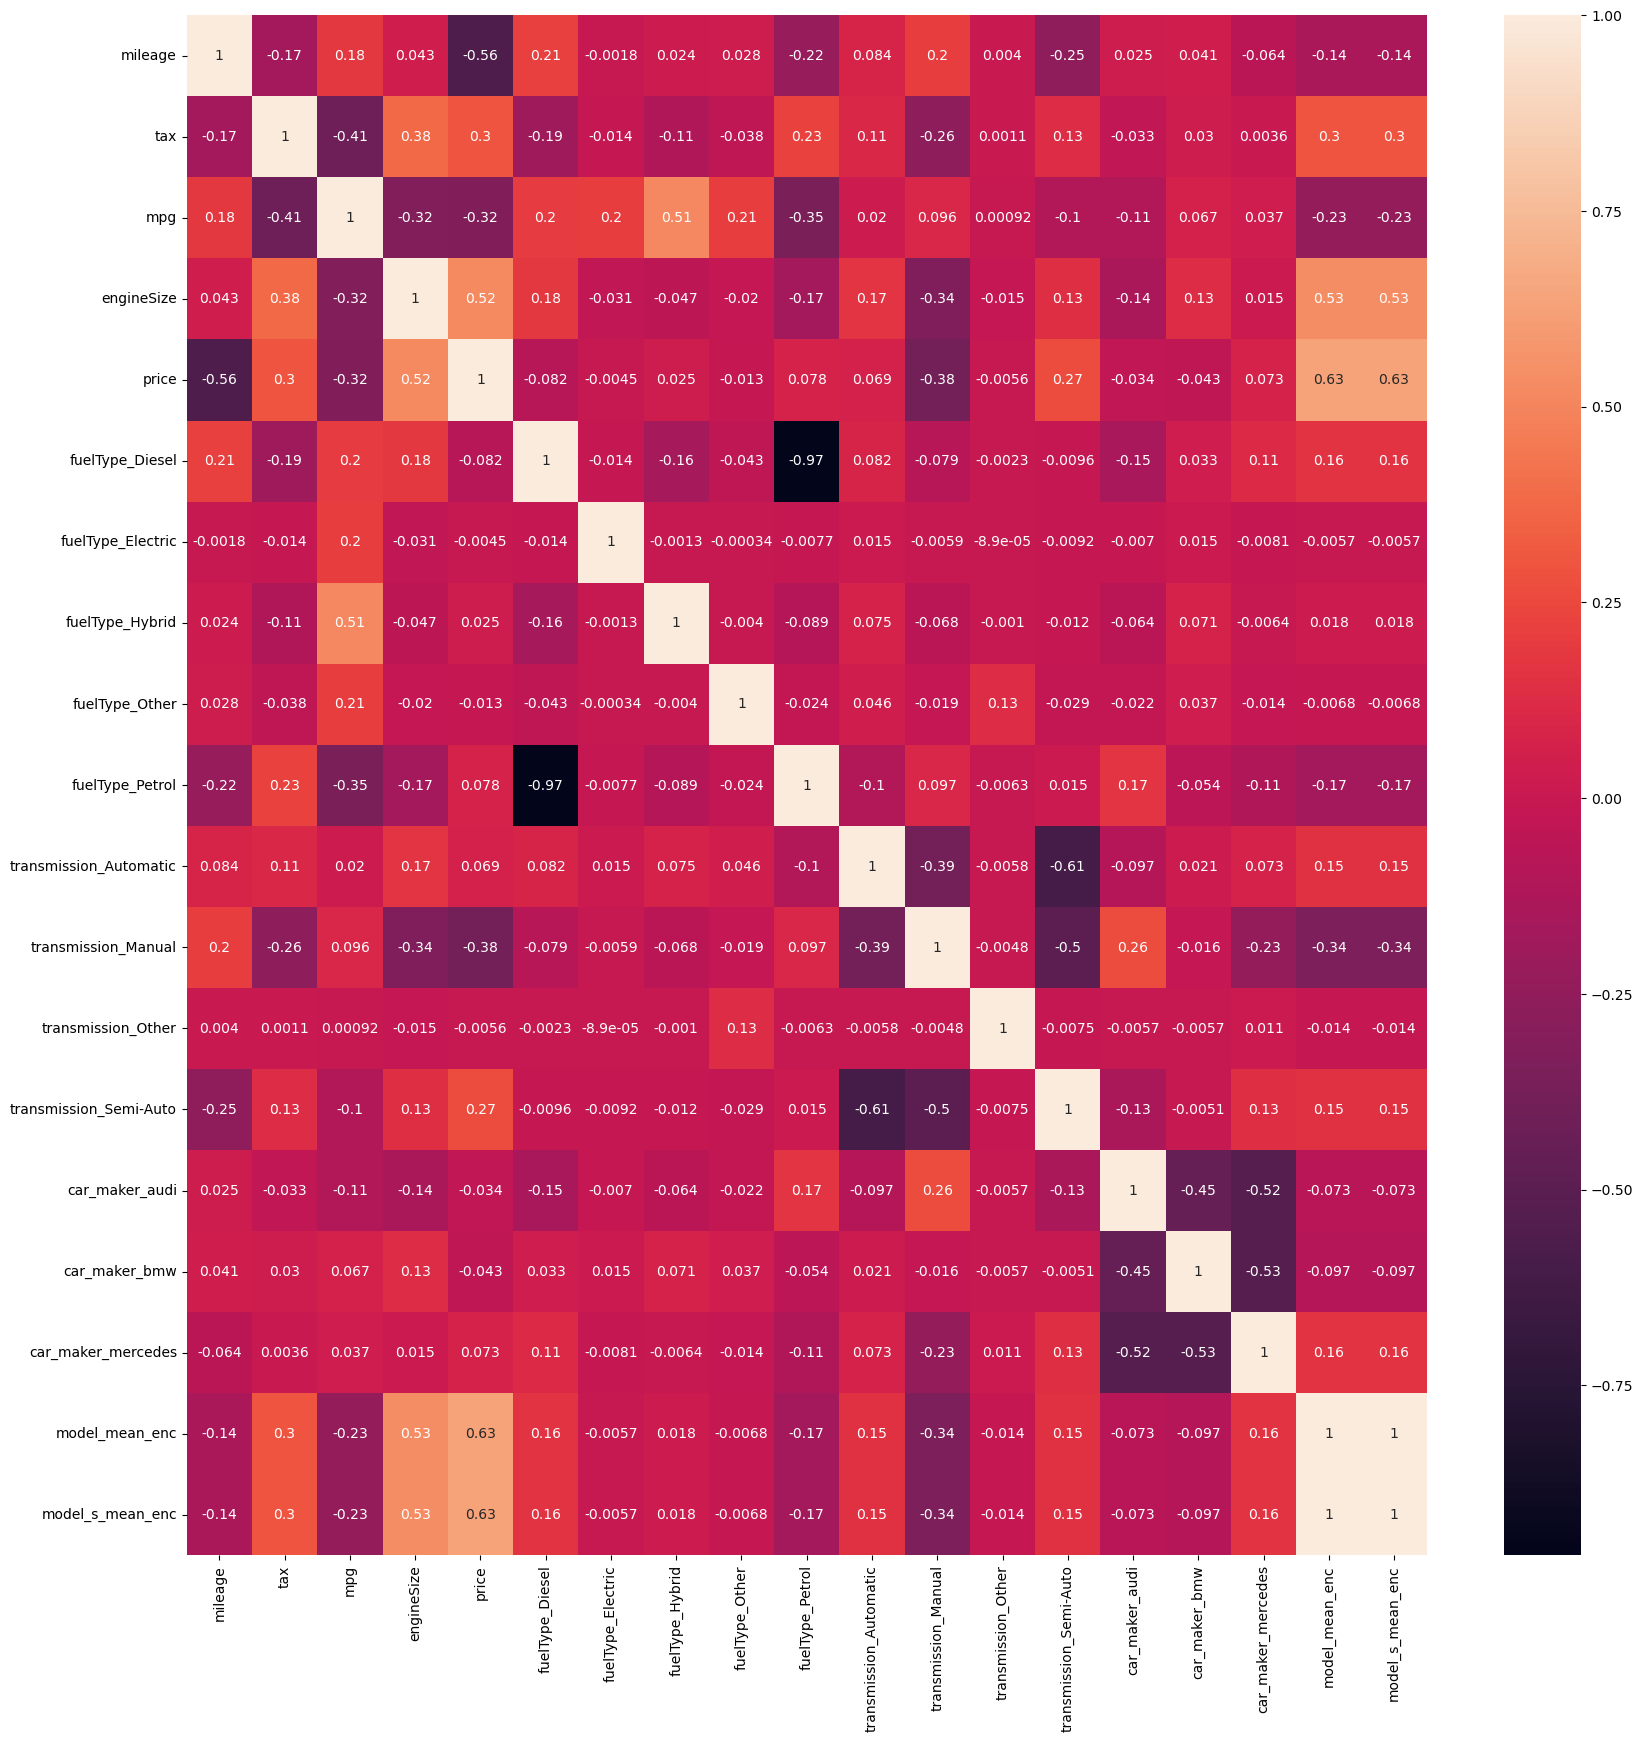

In [ ]:
print('CAR PREMIUM CORRELATIONS')
plt. figure(figsize=(20,20))
sns.heatmap(X_premium[['mileage', 'tax', 'mpg', 'engineSize', 'price',
       'fuelType_Diesel', 'fuelType_Electric', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'car_maker_audi', 'car_maker_bmw', 'car_maker_mercedes', 'model_mean_enc', 'model_s_mean_enc']].corr(), annot = True)

CAR STANDARD CORRELATIONS


<AxesSubplot:>

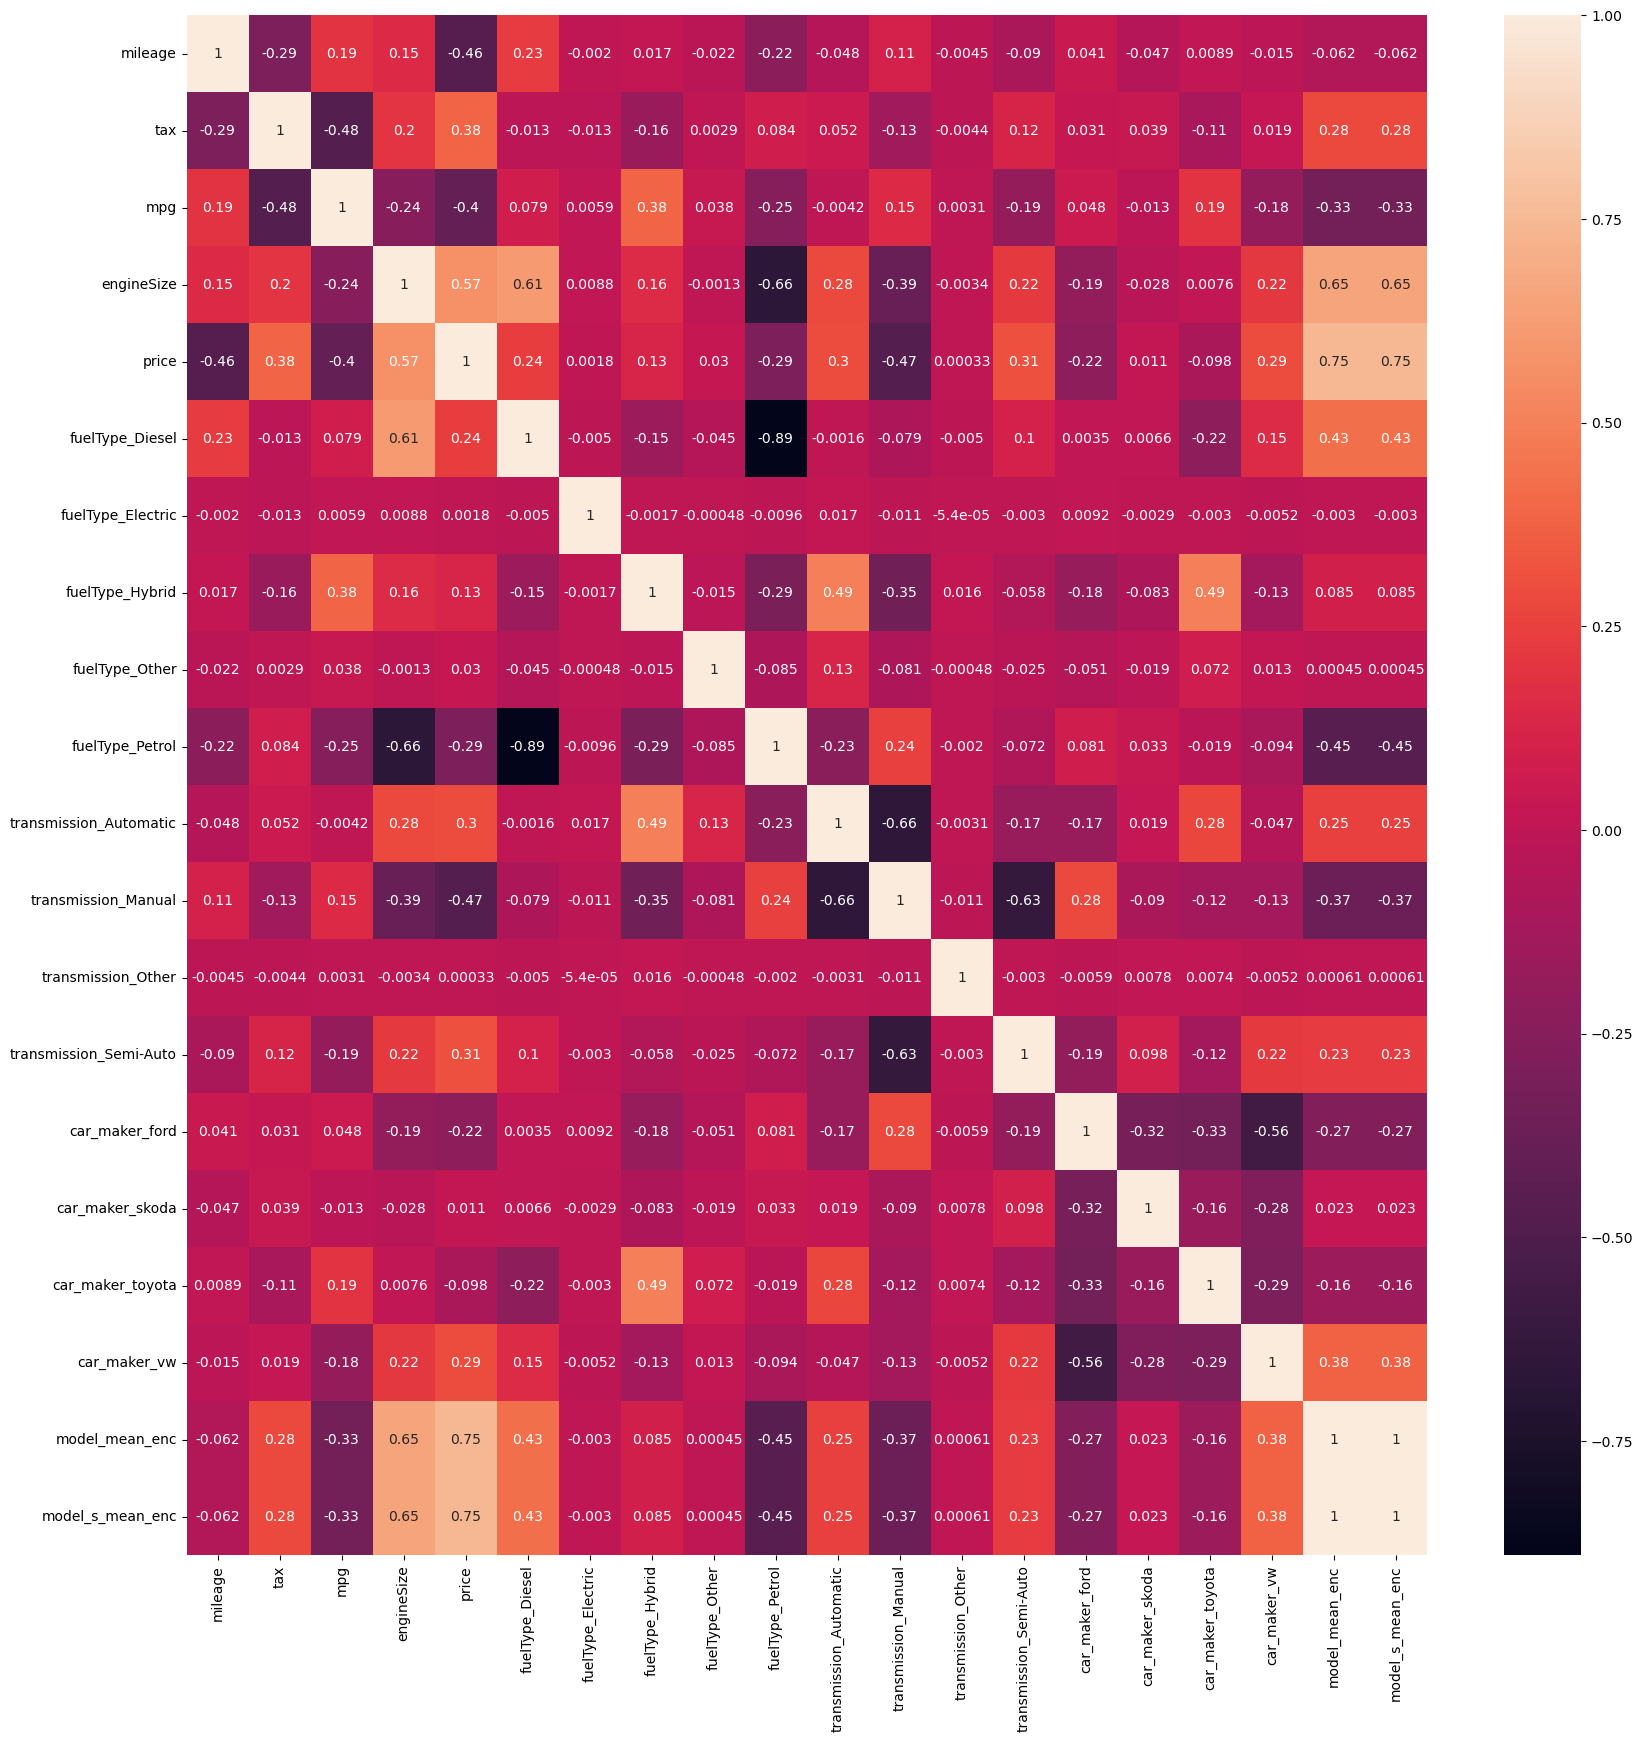

In [ ]:
print('CAR STANDARD CORRELATIONS')
plt. figure(figsize=(20,20))
sns.heatmap(X_standard[['mileage', 'tax', 'mpg', 'engineSize', 'price',
       'fuelType_Diesel', 'fuelType_Electric', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'car_maker_ford', 'car_maker_skoda', 'car_maker_toyota',
       'car_maker_vw', 'model_mean_enc', 'model_s_mean_enc']].corr(), annot = True)

В обеих группах наблюдается сильная отрицательная корреляция между видами топлива fuelType_Petrol / fuelType_Diesel, что логично. Удалим одну из фичей для исключения мультиколлинеарности:

In [ ]:
X_premium.drop(columns = 'fuelType_Diesel', inplace = True)
X_standard.drop(columns = 'fuelType_Diesel', inplace = True)

### Поисследуем количественные фичи и таргет на предмет наличия выбросов  
Используем интерквартильный размах (интервал, ограниченный усами boxplot, внутри которого лежит более 99.3% выборки. Все, что лежит за усами - это выбросы). Усы коробки соответствуют значениям

$$
Q_{1} - 1.5\times IQR
$$
и
$$
Q_{3} + 1.5\times IQR.
$$

<AxesSubplot:>

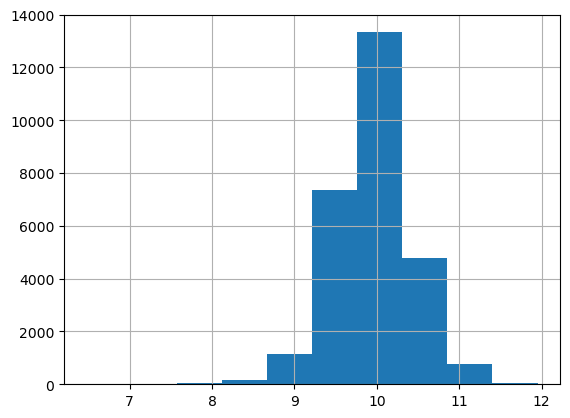

In [ ]:
# начнем с таргета
X_premium.log_price.hist()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

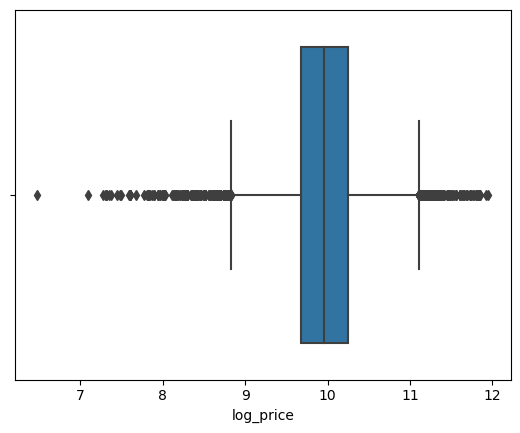

In [ ]:
sns.boxplot(X_premium.log_price)

Boxplot подтверждает наличие выбросов с обеих сторон. Удалим соответствующие записи, предварительно рассчитав нижнюю и верхнюю квартили, а также интерквартилльный размах

In [ ]:
def get_Q1_Q3_IDR(X, col):
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    Q1_IQR = Q1 - 1.5 * IQR
    Q3_IQR = Q3 + 1.5 * IQR

    print("Q1 = {s[0]}\n\
Q3 = {s[1]}\n\
IQR = {s[2]}\n\
Q1 - 1.5 IQR = {s[3]}\n\
Q3 + 1.5 IQR = {s[4]}".format(s = [Q1, Q3, IQR, Q1_IQR, Q3_IQR]))

    return (Q1_IQR, Q3_IQR)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_premium, 'log_price')

Q1 = 9.6798126085923
Q3 = 10.250581747317963
IQR = 0.5707691387256624
Q1 - 1.5 IQR = 8.823658900503807
Q3 + 1.5 IQR = 11.106735455406456


In [ ]:
def del_outliers(data, left, right, perem):
    return data[(data[perem] > left) & (data[perem] < right)]

In [ ]:
# итоговый трейн без выбросов
X_premium = del_outliers(X_premium, Q1_IQR, Q3_IQR, 'log_price')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

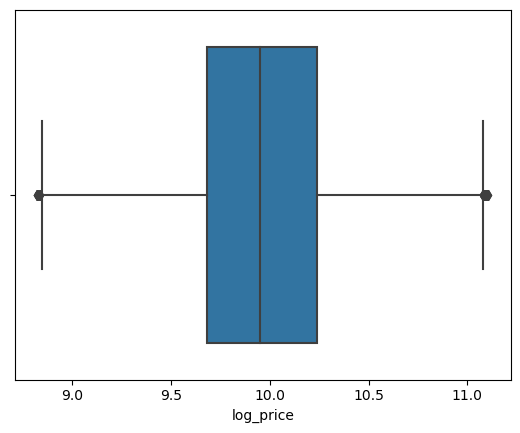

In [ ]:
sns.boxplot(X_premium.log_price)

<AxesSubplot:>

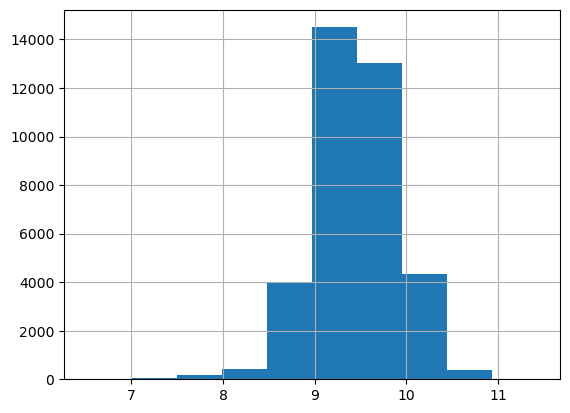

In [ ]:
# а что с ценой категории стандарт
X_standard.log_price.hist()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

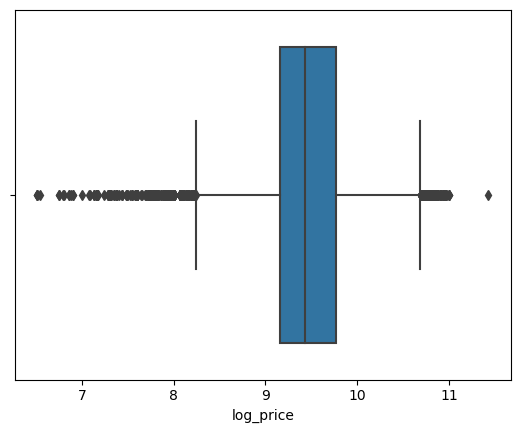

In [ ]:
sns.boxplot(X_standard.log_price)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_standard, 'log_price')

Q1 = 9.158520623246385
Q3 = 9.769956159911606
IQR = 0.6114355366652209
Q1 - 1.5 IQR = 8.241367318248553
Q3 + 1.5 IQR = 10.687109464909437


In [ ]:
# итоговый трейн без выбросов
X_standard = del_outliers(X_standard, Q1_IQR, Q3_IQR, 'log_price')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

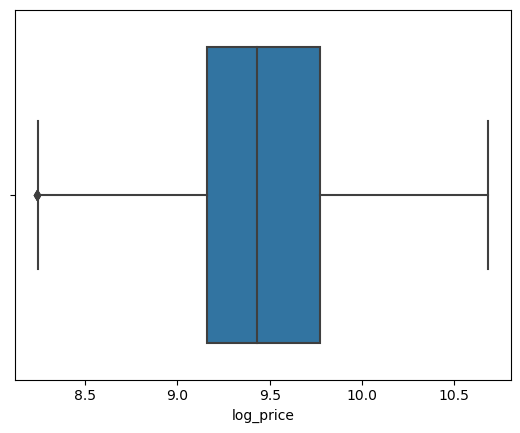

In [ ]:
sns.boxplot(X_standard.log_price)

<AxesSubplot:>

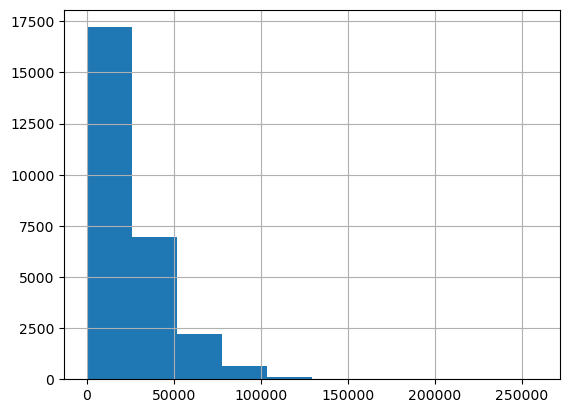

In [ ]:
# оценим распределение пробега по классу премиум
X_premium.mileage.hist()

<AxesSubplot:>

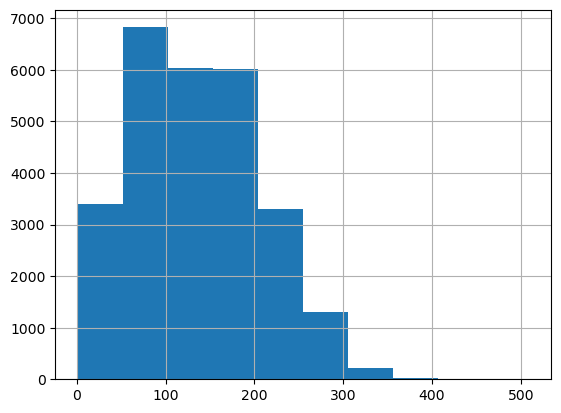

In [ ]:
# унимодально, скошено влево, попробуем преобразовать
np.sqrt(X_premium.mileage).hist()

<AxesSubplot:>

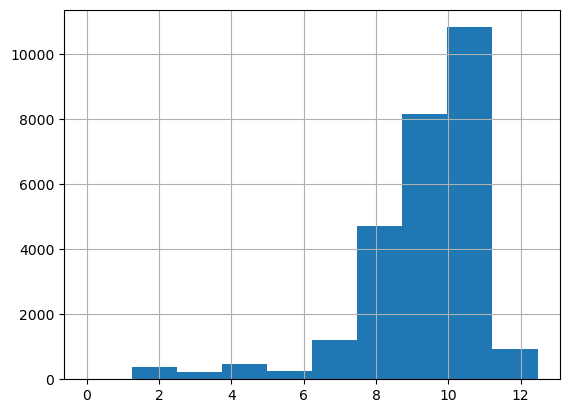

In [ ]:
np.log(X_premium.mileage).hist()

In [ ]:
# заменим параметр
X_premium['sqrt_mileage'] = np.sqrt(X_premium.mileage)
X_premium.drop(columns = 'mileage', inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_9336\2381957847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_premium['sqrt_mileage'] = np.sqrt(X_premium.mileage)
C:\Users\User\AppData\Local\Temp\ipykernel_9336\2381957847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_premium.drop(columns = 'mileage', inplace = True)


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mileage'>

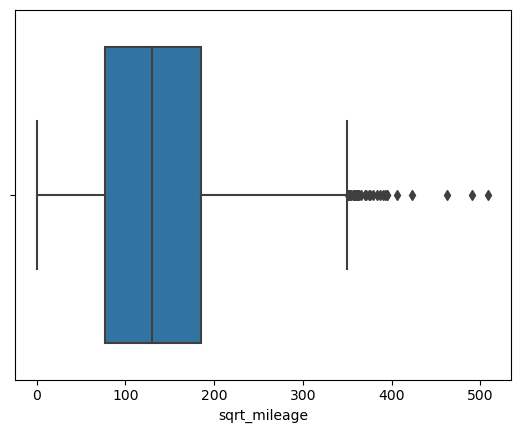

In [ ]:
sns.boxplot(X_premium.sqrt_mileage)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_premium, 'sqrt_mileage')

Q1 = 76.64202502543888
Q3 = 185.76059862091316
IQR = 109.11857359547427
Q1 - 1.5 IQR = -87.03583536777252
Q3 + 1.5 IQR = 349.43845901412453


In [ ]:
# итоговый премиум трейн без выбросов пробега
X_premium = del_outliers(X_premium, Q1_IQR, Q3_IQR, 'sqrt_mileage')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mileage'>

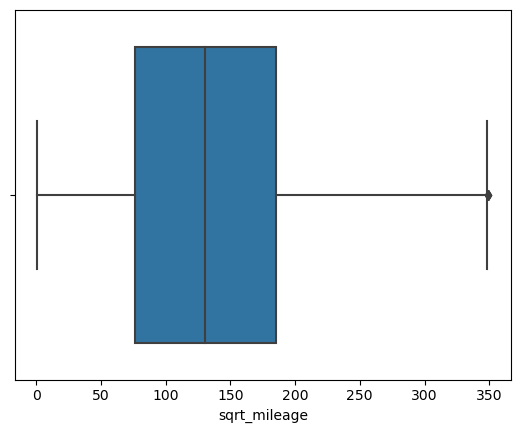

In [ ]:
sns.boxplot(X_premium.sqrt_mileage)

<AxesSubplot:>

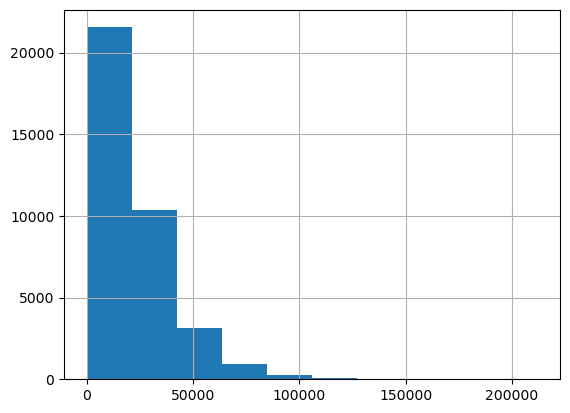

In [ ]:
# аналогично стандарт
X_standard.mileage.hist()

<AxesSubplot:>

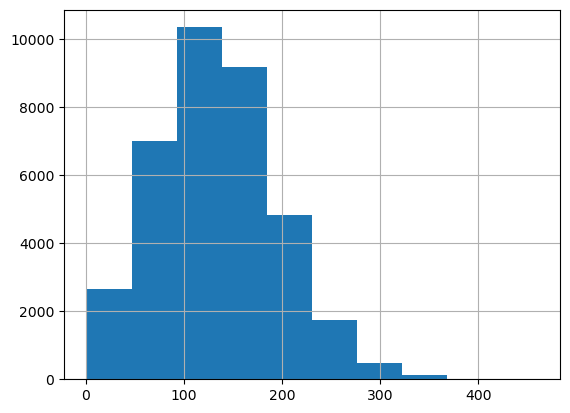

In [ ]:
# унимодально, скошено влево, попробуем преобразовать
np.sqrt(X_standard.mileage).hist()

<AxesSubplot:>

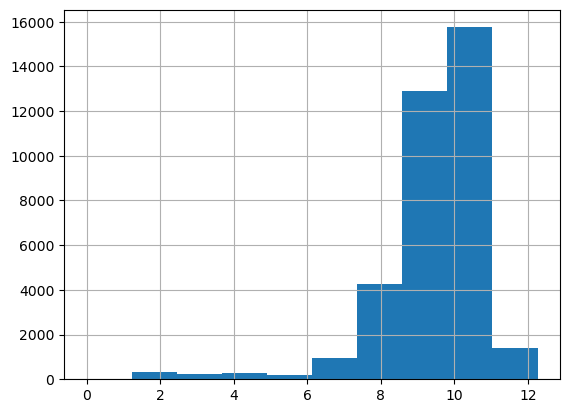

In [ ]:
np.log(X_standard.mileage).hist()

In [ ]:
# заменим параметр
X_standard['sqrt_mileage'] = np.sqrt(X_standard.mileage)
X_standard.drop(columns = 'mileage', inplace = True)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mileage'>

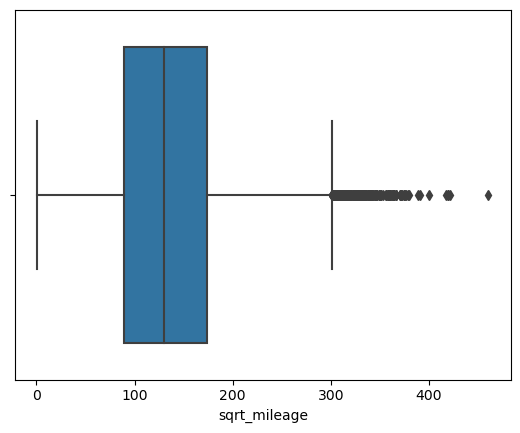

In [ ]:
sns.boxplot(X_standard.sqrt_mileage)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_standard, 'sqrt_mileage')

Q1 = 89.48184173339304
Q3 = 174.19816302131318
IQR = 84.71632128792014
Q1 - 1.5 IQR = -37.59264019848716
Q3 + 1.5 IQR = 301.2726449531934


In [ ]:
# итоговый трейн без выбросов
X_standard = del_outliers(X_standard, Q1_IQR, Q3_IQR, 'sqrt_mileage')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mileage'>

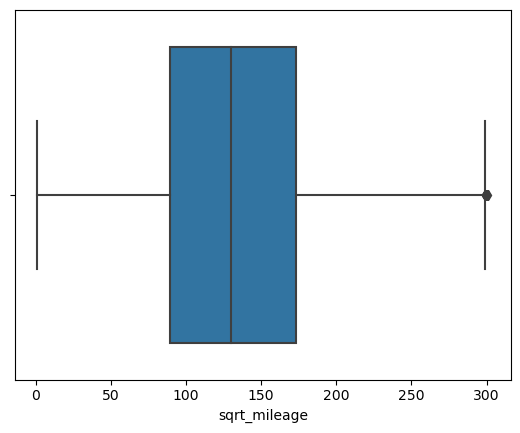

In [ ]:
sns.boxplot(X_standard.sqrt_mileage)

<AxesSubplot:>

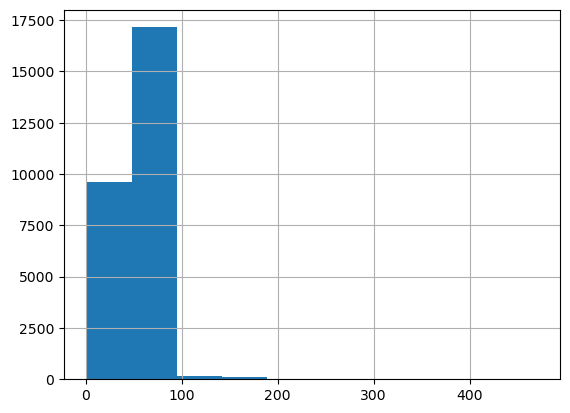

In [ ]:
# распределение показателя экономичности премиум авто
X_premium.mpg.hist()

<AxesSubplot:>

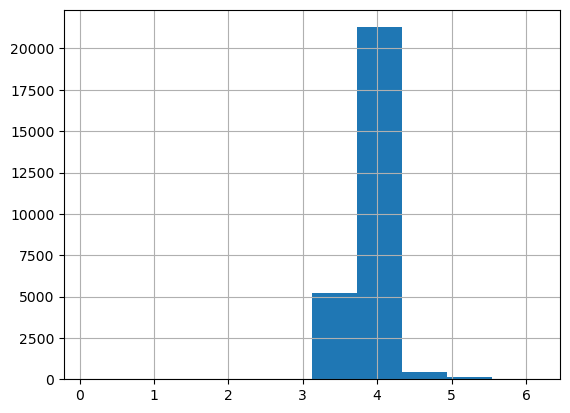

In [ ]:
np.log(X_premium.mpg).hist()

<AxesSubplot:>

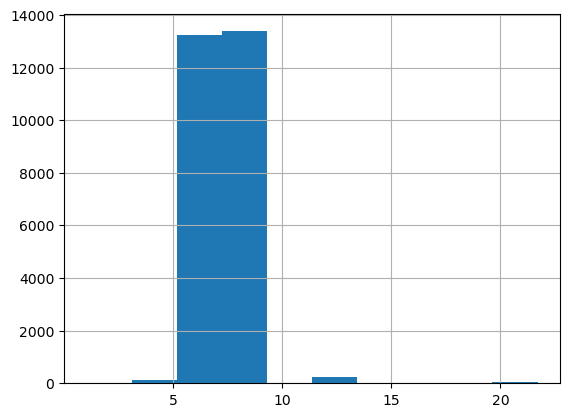

In [ ]:
np.sqrt(X_premium.mpg).hist()

In [ ]:
# преобразуем показатель
X_premium['sqrt_mpg'] = np.sqrt(X_premium.mpg)
X_premium.drop(columns = 'mpg', inplace = True)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mpg'>

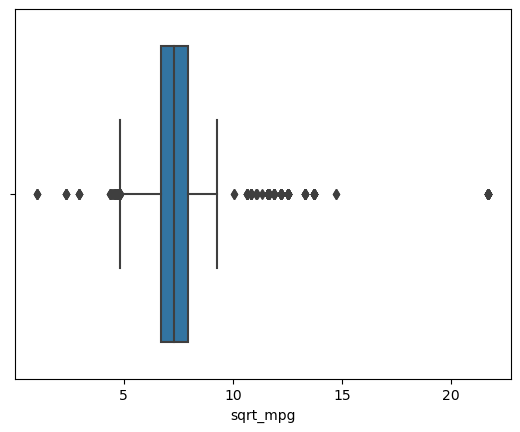

In [ ]:
sns.boxplot(X_premium.sqrt_mpg)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_premium, 'sqrt_mpg')

Q1 = 6.6932802122726045
Q3 = 7.92464510246358
IQR = 1.2313648901909753
Q1 - 1.5 IQR = 4.846232876986141
Q3 + 1.5 IQR = 9.771692437750042


In [ ]:
# итоговый трейн без выбросов
X_premium = del_outliers(X_premium, Q1_IQR, Q3_IQR, 'sqrt_mpg')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mpg'>

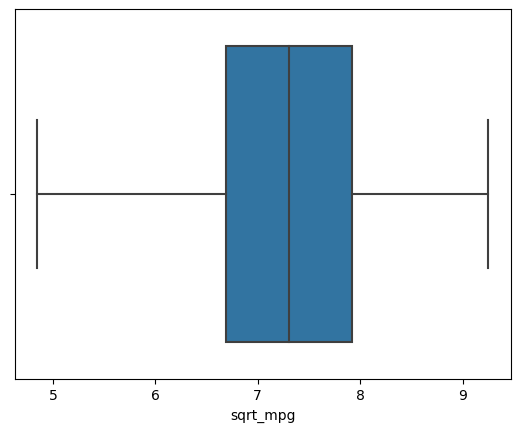

In [ ]:
sns.boxplot(X_premium.sqrt_mpg)

<AxesSubplot:>

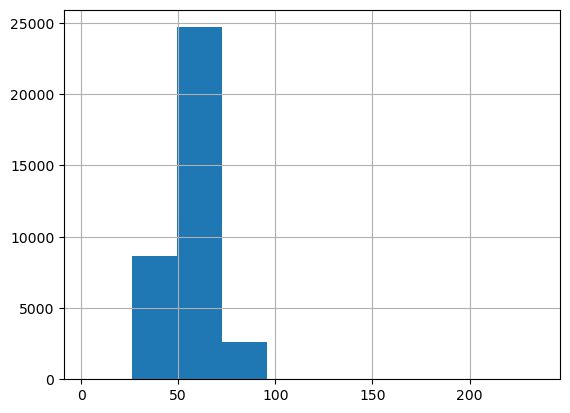

In [ ]:
# распределение показателя экономичности стандарт авто
X_standard.mpg.hist()

<AxesSubplot:>

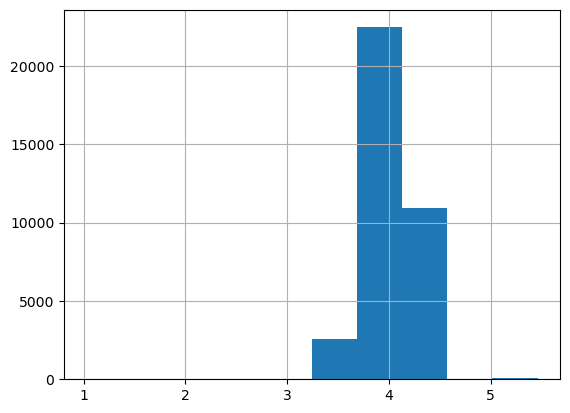

In [ ]:
np.log(X_standard.mpg).hist()

<AxesSubplot:>

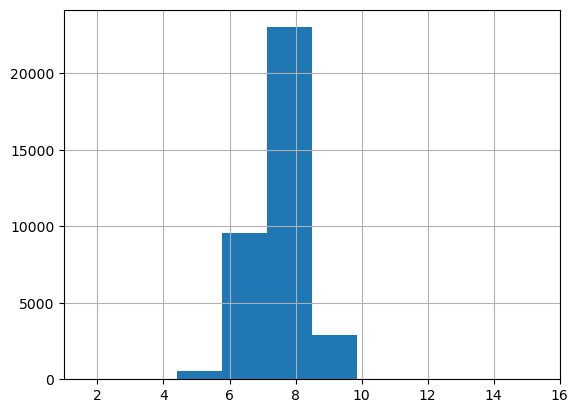

In [ ]:
np.sqrt(X_standard.mpg).hist()

In [ ]:
# преобразуем показатель
X_standard['sqrt_mpg'] = np.sqrt(X_standard.mpg)
X_standard.drop(columns = 'mpg', inplace = True)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mpg'>

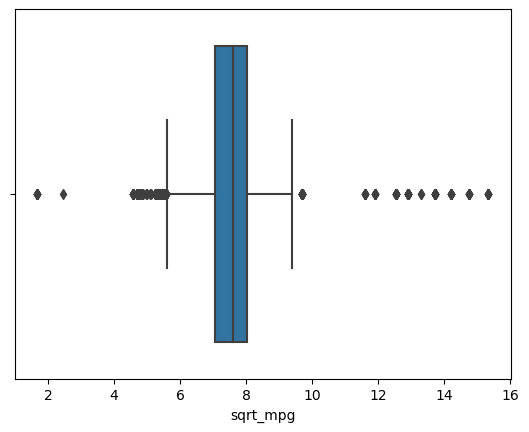

In [ ]:
sns.boxplot(X_standard.sqrt_mpg)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_standard, 'sqrt_mpg')

Q1 = 7.042726744663604
Q3 = 8.012490249604053
IQR = 0.9697635049404489
Q1 - 1.5 IQR = 5.58808148725293
Q3 + 1.5 IQR = 9.467135507014726


In [ ]:
# итоговый трейн без выбросов
X_standard = del_outliers(X_standard, Q1_IQR, Q3_IQR, 'sqrt_mpg')

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqrt_mpg'>

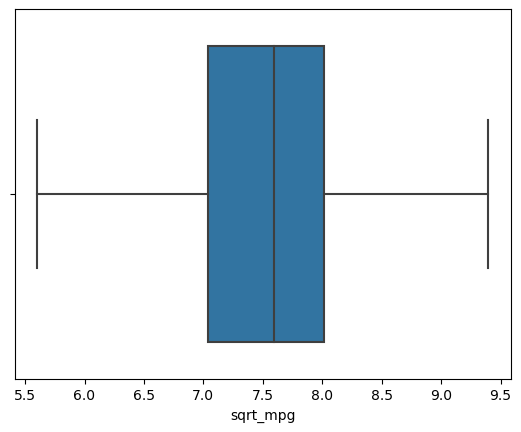

In [ ]:
sns.boxplot(X_standard.sqrt_mpg)

<AxesSubplot:>

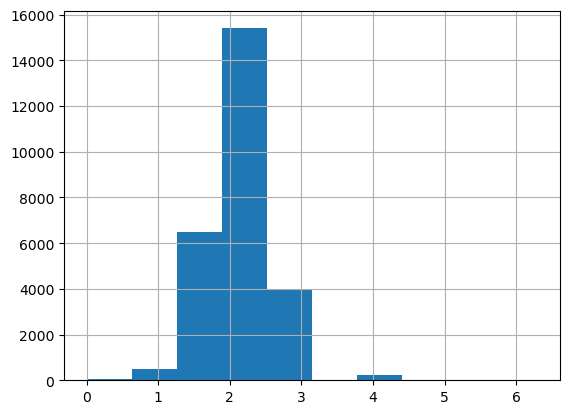

In [ ]:
# посмотрим на размеры двигателей машин премиум класса
X_premium.engineSize.hist()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='engineSize'>

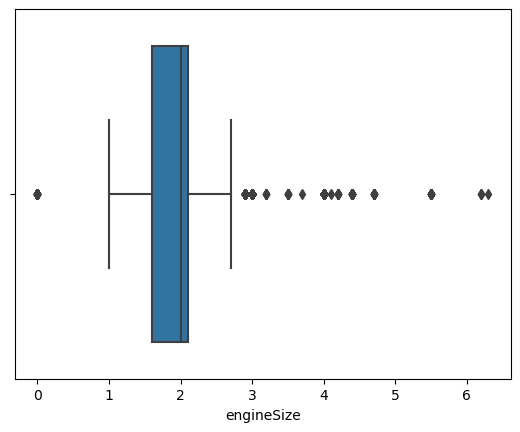

In [ ]:
sns.boxplot(X_premium.engineSize)

In [ ]:
Q1_IQR, Q3_IQR = get_Q1_Q3_IDR(X_premium, 'engineSize')

Q1 = 1.6
Q3 = 2.1
IQR = 0.5
Q1 - 1.5 IQR = 0.8500000000000001
Q3 + 1.5 IQR = 2.85


In [ ]:
# итоговый трейн без выбросов
X_premium = del_outliers(X_premium, Q1_IQR, Q3_IQR, 'engineSize')

<AxesSubplot:>

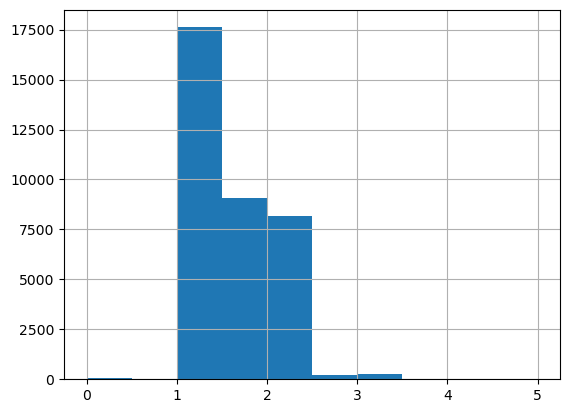

In [ ]:
# двигатели класса стандарт
X_standard.engineSize.hist()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='engineSize'>

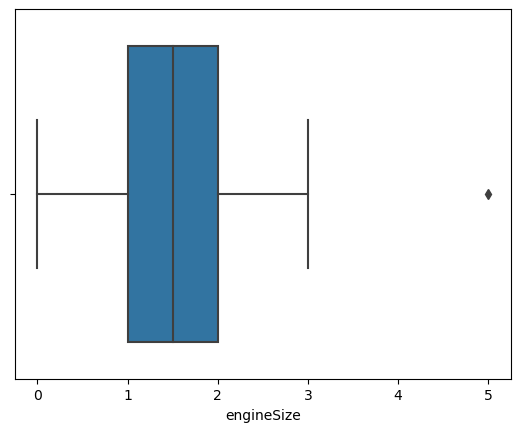

In [ ]:
sns.boxplot(X_standard.engineSize)

In [ ]:
X_standard = X_standard.query('engineSize < 4')

### Нормализуем количественные признаки  

In [ ]:
quant_lst = ['tax', 'engineSize', 'sqrt_mileage', 'sqrt_mpg']
from sklearn.preprocessing import StandardScaler
X_standard[quant_lst] = StandardScaler().fit_transform(X_standard[quant_lst])
X_premium[quant_lst] = StandardScaler().fit_transform(X_premium[quant_lst])

### Допилим тест

In [ ]:
X_premium_test = pd.concat([X_test.query('car_maker_audi == 1'),
                       X_test.query('car_maker_bmw == 1'),
                       X_test.query('car_maker_mercedes == 1')])

X_standard_test = pd.concat([X_test.query('car_maker_ford == 1'),
                        X_test.query('car_maker_toyota == 1'),
                        X_test.query('car_maker_skoda == 1'),
                        X_test.query('car_maker_vw == 1')])

# заменим параметры
X_premium_test['sqrt_mileage'] = np.sqrt(X_premium_test.mileage)
X_premium_test.drop(columns = 'mileage', inplace = True)
X_standard_test['sqrt_mileage'] = np.sqrt(X_standard_test.mileage)
X_standard_test.drop(columns = 'mileage', inplace = True)

X_premium_test['sqrt_mpg'] = np.sqrt(X_premium_test.mpg)
X_premium_test.drop(columns = 'mpg', inplace = True)
X_standard_test['sqrt_mpg'] = np.sqrt(X_standard_test.mpg)
X_standard_test.drop(columns = 'mpg', inplace = True)

# нормализуем количественные
X_standard_test[quant_lst] = StandardScaler().fit_transform(X_standard_test[quant_lst])
X_premium_test[quant_lst] = StandardScaler().fit_transform(X_premium_test[quant_lst])

### Построение моделей  

In [ ]:
from sklearn.utils import shuffle
# Перемешаем данные и отделим целевую переменную от предикторов
X_premium = shuffle(X_premium, random_state = 123)
X_standard = shuffle(X_standard, random_state = 123)

In [ ]:
# подготовим данные для обучения
X_prem_me, y_prem_me = X_premium.drop(columns = ['price', 'log_price', 'id', 'model_s_mean_enc'], axis = 1), X_premium.log_price
X_stand_me, y_stand_me = X_standard.drop(columns = ['price', 'log_price', 'id', 'model_s_mean_enc'], axis = 1), X_standard.log_price

In [ ]:
X_prem_mse, y_prem_mse = X_premium.drop(columns = ['price', 'log_price', 'id', 'model_mean_enc'], axis = 1), X_premium.log_price
X_stand_mse, y_stand_mse = X_standard.drop(columns = ['price', 'log_price', 'id', 'model_mean_enc'], axis = 1), X_standard.log_price

In [ ]:
# методы кросс валидации, заточенные под линейные модели
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange
cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= 1 )

In [ ]:
X_prem_me = X_prem_me.apply(pd.to_numeric, errors='coerce')
y_prem_me = y_prem_me.apply(pd.to_numeric, errors='coerce')
X_prem_mse = X_prem_mse.apply(pd.to_numeric, errors='coerce')
y_prem_mse = y_prem_mse.apply(pd.to_numeric, errors='coerce')

In [ ]:
# премиум mean encoding
linreg_prem_me = LinearRegression().fit(X_prem_me, y_prem_me)
lasso_cv_prem_me = LassoCV(cv = cv).fit(X_prem_me, y_prem_me)
ridge_cv_prem_me = RidgeCV(cv=cv).fit(X_prem_me, y_prem_me)

In [ ]:
# премиум mean smoothed encoding
linreg_prem_mse = LinearRegression().fit(X_prem_mse, y_prem_mse)
lasso_cv_prem_mse = LassoCV(cv = cv).fit(X_prem_mse, y_prem_mse)
ridge_cv_prem_mse = RidgeCV(cv=cv).fit(X_prem_mse, y_prem_mse)

In [ ]:
# стандарт mean encoding
linreg_stand_me = LinearRegression().fit(X_stand_me, y_stand_me)
lasso_cv_stand_me = LassoCV(alphas= arange (0, 1, 0.01), cv=cv, n_jobs=-1).fit(X_stand_me, y_stand_me)
ridge_cv_stand_me = RidgeCV(alphas= arange (0.1, 1.0, 10.0), cv=cv).fit(X_stand_me, y_stand_me)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with

In [ ]:
# стандарт mean smoothed encoding
linreg_stand_mse = LinearRegression().fit(X_stand_mse, y_stand_mse)
lasso_cv_stand_mse = LassoCV(alphas= arange (0, 1, 0.01), cv=cv, n_jobs=-1).fit(X_stand_mse, y_stand_mse)
ridge_cv_stand_mse = RidgeCV(alphas= arange (0.1, 1.0, 10.0), cv=cv).fit(X_stand_mse, y_stand_mse)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with

In [ ]:
print('MAE for premium cars')
pd.DataFrame({'Model_type' : ['LinReg', 'Lasso', 'Ridge'],
                            'MAE_MeanEncoding': [mean_absolute_error(np.exp(y_prem_me), np.exp(linreg_prem_me.predict(X_prem_me))),
                                             mean_absolute_error(np.exp(y_prem_me), np.exp(lasso_cv_prem_me.predict(X_prem_me))),
                                             mean_absolute_error(np.exp(y_prem_me), np.exp(ridge_cv_prem_me.predict(X_prem_me)))],
                            'MAE_SmoothedEncoding': [mean_absolute_error(np.exp(y_prem_mse), np.exp(linreg_prem_mse.predict(X_prem_mse))),
                                             mean_absolute_error(np.exp(y_prem_mse), np.exp(lasso_cv_prem_mse.predict(X_prem_mse))),
                                             mean_absolute_error(np.exp(y_prem_mse), np.exp(ridge_cv_prem_mse.predict(X_prem_mse))) ]})

MAE for premium cars


,Model_type,MAE_MeanEncoding,MAE_SmoothedEncoding
0,LinReg,2044.307101,2044.825646
1,Lasso,2056.897494,2056.897494
2,Ridge,2044.593357,2044.593357


In [ ]:
print('MAE for standard cars')
pd.DataFrame({'Model_type' : ['LinReg', 'Lasso', 'Ridge'],
                            'MAE_MeanEncoding': [mean_absolute_error(np.exp(y_stand_me), np.exp(linreg_stand_me.predict(X_stand_me))),
                                             mean_absolute_error(np.exp(y_stand_me), np.exp(lasso_cv_stand_me.predict(X_stand_me))),
                                             mean_absolute_error(np.exp(y_stand_me), np.exp(ridge_cv_stand_me.predict(X_stand_me)))],
                            'MAE_SmoothedEncoding': [mean_absolute_error(np.exp(y_stand_mse), np.exp(linreg_stand_mse.predict(X_stand_mse))),
                                             mean_absolute_error(np.exp(y_stand_mse), np.exp(lasso_cv_stand_mse.predict(X_stand_mse))),
                                             mean_absolute_error(np.exp(y_stand_mse), np.exp(ridge_cv_stand_mse.predict(X_stand_mse))) ]})

MAE for standard cars


,Model_type,MAE_MeanEncoding,MAE_SmoothedEncoding
0,LinReg,1438.074081,1437.895993
1,Lasso,1438.075766,1438.075766
2,Ridge,1438.096046,1438.096046
